In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from sklearn.decomposition import PCA
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.tree import plot_tree
from imblearn import over_sampling

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

data = pd.read_csv("M:/DataSet/usaccident/real/selectData.csv",index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212697 entries, 0 to 212696
Columns: 312 entries, TMC to yorkrockhillkuza29730
dtypes: float64(10), int64(302)
memory usage: 507.9 MB


In [2]:
Y = data['Severity']
X = data.drop(["Severity"], axis=1)

del data

X.shape, Y.shape

((212697, 311), (212697,))

Part Ⅰ 
=

1.划分数据集
=

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10,stratify=Y_train)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((136125, 311), (42540, 311), (34032, 311), (136125,), (42540,), (34032,))

2.PCA
=
Note:<br>
先标准化再PCA的原因<br>
ANS：<br>
PCA通常用于高维数据的降维，它可以将原来高维的数据投影到某个低维空间并使其方差尽可能大<br>
如果数据某一列数值特别大，那么他在整个误差计算的比重就很大，因此在投影到低维空间后，为了使<br>
低秩分解逼近原数据，整个投影会努力逼近最大的那个特征，而忽略数值比较小的特征，因为建模前<br>
我们不知道各个特征的重要性，这样就很可能造成大量信息丢失，因此为了防止捕捉哪些数值过大的特征<br>
需要在PCA前进行标准化<br>
<br>实例：如果这里不经标准化就PCA，当设定 n_components=0.99时，只有4个特征；标准化后再PCA则为19个特征

In [4]:
pca = PCA(n_components=0.9999)
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())
print(len(pca.explained_variance_))

0.9999014000578292
207


In [5]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((136125, 207), (42540, 207), (34032, 207))

3.OverSampling
=

In [6]:
ros = over_sampling.RandomOverSampler(random_state=12)

X_train, Y_train = ros.fit_resample(X_train, Y_train)

print(sorted(Counter(Y_train).items()))

[(1, 111548), (2, 111548), (3, 111548), (4, 111548)]


4.Model
=

DecisionTree
=

In [7]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)

pred_dt = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train[:30000])

mat_train = confusion_matrix(Y_train[:30000],y_train_pred)
mat_dt = confusion_matrix(Y_test, pred_dt)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_dt}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_dt))

del pred_dt, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    0 24652    13    22]
 [    0     0  5064     0]
 [    0     0     0   234]]

confusion matrix :
[[    4    19     2     0]
 [   21 31445  3176   217]
 [    4  3503  3768    52]
 [    0   182    53    94]]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00     24687
           3       1.00      1.00      1.00      5064
           4       0.91      1.00      0.96       234

    accuracy                           1.00     30000
   macro avg       0.98      1.00      0.99     30000
weighted avg       1.00      1.00      1.00     30000

              precision    recall  f1-score   support

           1       0.14      0.16      0.15        25
           2       0.89      0.90      0.90     34859
           3       0.54      0.51      0.53      7327
           4       0.26      0.29      0.27       329

    accuracy                       

In [8]:
dt_params = {
    'criterion':['gini','entropy'],
    'max_depth':[8,10,12,14,16]
}
clf = GridSearchCV(dtree, param_grid=dt_params,cv=5,scoring='recall',n_jobs=-1)
clf.fit(X_val, Y_val)


dtree = DecisionTreeClassifier(**clf.best_params_)
dtree.fit(X_train, Y_train)

pred_dt = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train[:30000])

mat_train = confusion_matrix(Y_train[:30000],y_train_pred)
mat_dt = confusion_matrix(Y_test, pred_dt)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_dt}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_dt))

del pred_dt, y_train_pred

confusion matrix :
[[   14     0     1     0]
 [  454 13035  8533  2665]
 [   47   401  4316   300]
 [    1     1    12   220]]

confusion matrix :
[[   11    10     4     0]
 [  693 18252 12243  3671]
 [   66   639  6181   441]
 [    2    43    31   253]]

              precision    recall  f1-score   support

           1       0.03      0.93      0.05        15
           2       0.97      0.53      0.68     24687
           3       0.34      0.85      0.48      5064
           4       0.07      0.94      0.13       234

    accuracy                           0.59     30000
   macro avg       0.35      0.81      0.34     30000
weighted avg       0.86      0.59      0.65     30000

              precision    recall  f1-score   support

           1       0.01      0.44      0.03        25
           2       0.96      0.52      0.68     34859
           3       0.33      0.84      0.48      7327
           4       0.06      0.77      0.11       329

    accuracy                       

RandomForest
=

In [9]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=15)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train[:30000])

mat_rfc = confusion_matrix(Y_test, pred_rfc)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_rfc}\n")

print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_rfc))

del pred_rfc, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    6 20003  4342   336]
 [    0    59  4943    62]
 [    0     0     0   234]]

confusion matrix :
[[    5    18     2     0]
 [    7 27362  6895   595]
 [    1   718  6428   180]
 [    0   115    30   184]]

              precision    recall  f1-score   support

           1       0.71      1.00      0.83        15
           2       1.00      0.81      0.89     24687
           3       0.53      0.98      0.69      5064
           4       0.37      1.00      0.54       234

    accuracy                           0.84     30000
   macro avg       0.65      0.95      0.74     30000
weighted avg       0.91      0.84      0.86     30000

              precision    recall  f1-score   support

           1       0.38      0.20      0.26        25
           2       0.97      0.78      0.87     34859
           3       0.48      0.88      0.62      7327
           4       0.19      0.56      0.29       329

    accuracy                       

In [10]:
rfc_params = {
    "n_estimators" : [150, 200],
    'max_depth' : [11,15,19]
}
clf = GridSearchCV(rfc, param_grid=rfc_params, scoring='recall',cv=5,n_jobs=-1)
clf.fit(X_val, Y_val)

rfc = RandomForestClassifier(**clf.best_params_)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train[:30000])

mat_rfc = confusion_matrix(Y_test, pred_rfc)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)


print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_rfc}\n")

print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_rfc))

del pred_rfc,y_train_pred

confusion matrix :
[[   15     0     0     0]
 [   15 18095  5412  1165]
 [    1   211  4673   179]
 [    0     0     4   230]]

confusion matrix :
[[    6    17     2     0]
 [   21 25140  7987  1711]
 [    3   616  6381   327]
 [    0    71    26   232]]

              precision    recall  f1-score   support

           1       0.48      1.00      0.65        15
           2       0.99      0.73      0.84     24687
           3       0.46      0.92      0.62      5064
           4       0.15      0.98      0.25       234

    accuracy                           0.77     30000
   macro avg       0.52      0.91      0.59     30000
weighted avg       0.89      0.77      0.80     30000

              precision    recall  f1-score   support

           1       0.20      0.24      0.22        25
           2       0.97      0.72      0.83     34859
           3       0.44      0.87      0.59      7327
           4       0.10      0.71      0.18       329

    accuracy                       

XGB
=

In [11]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train[:30000])

mat_xgb = confusion_matrix(Y_test, pred_xgb)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_xgb}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_xgb))

del pred_xgb, y_train_pred

[11:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix :
[[   15     0     0     0]
 [    1 20190  4167   329]
 [    0   192  4840    32]
 [    0     0     0   234]]

confusion matrix :
[[    5    18     2     0]
 [    4 27901  6389   565]
 [    1   680  6501   145]
 [    0    98    49   182]]

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       0.99      0.82      0.90     24687
           3       0.54      0.96      0.69      5064
           4       0.39      1.00      0.56       234

    accuracy                           0.84     30000
   macro avg       0.71      0.94      0.78     30000
weighted avg       0.91      0.84      0.86     300

In [12]:
xgb_params = {
    'max_depth' : [1,3,5],
    'n_estimators' : [150,200]
}

clf = GridSearchCV(xgb, param_grid=xgb_params,cv=5,scoring='recall')
clf.fit(X_val, Y_val)


xgb = XGBClassifier(**clf.best_params_)
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train[:30000])

mat_xgb = confusion_matrix(Y_test, pred_xgb)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_xgb}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_xgb))

del pred_xgb, y_train_pred

[11:22:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[12:10:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

LGBM
=

In [13]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, Y_train)
pred_lgbm = lgbm.predict(X_test)
y_train_pred = lgbm.predict(X_train[:30000])

mat_lgbm = confusion_matrix(Y_test, pred_lgbm)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_lgbm}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_lgbm))

del pred_lgbm, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    7 19322  4691   667]
 [    0   289  4681    94]
 [    0     0     0   234]]

confusion matrix :
[[    8    13     4     0]
 [    8 26946  6903  1002]
 [    1   598  6507   221]
 [    0    66    32   231]]

              precision    recall  f1-score   support

           1       0.68      1.00      0.81        15
           2       0.99      0.78      0.87     24687
           3       0.50      0.92      0.65      5064
           4       0.24      1.00      0.38       234

    accuracy                           0.81     30000
   macro avg       0.60      0.93      0.68     30000
weighted avg       0.90      0.81      0.83     30000

              precision    recall  f1-score   support

           1       0.47      0.32      0.38        25
           2       0.98      0.77      0.86     34859
           3       0.48      0.89      0.63      7327
           4       0.16      0.70      0.26       329

    accuracy                       

CATBoost
=

In [14]:
cat = CatBoostClassifier()
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

Learning rate set to 0.108006
0:	learn: 1.2780253	total: 1.06s	remaining: 17m 40s
1:	learn: 1.1976163	total: 2s	remaining: 16m 37s
2:	learn: 1.1311887	total: 2.92s	remaining: 16m 10s
3:	learn: 1.0785918	total: 3.78s	remaining: 15m 42s
4:	learn: 1.0281566	total: 4.99s	remaining: 16m 33s
5:	learn: 0.9890995	total: 5.89s	remaining: 16m 16s
6:	learn: 0.9559753	total: 6.77s	remaining: 16m
7:	learn: 0.9223701	total: 7.76s	remaining: 16m 2s
8:	learn: 0.8960565	total: 8.56s	remaining: 15m 42s
9:	learn: 0.8687259	total: 9.55s	remaining: 15m 45s
10:	learn: 0.8416812	total: 10.6s	remaining: 15m 56s
11:	learn: 0.8211241	total: 11.5s	remaining: 15m 49s
12:	learn: 0.7981245	total: 12.6s	remaining: 15m 56s
13:	learn: 0.7780670	total: 13.5s	remaining: 15m 51s
14:	learn: 0.7632426	total: 14.4s	remaining: 15m 48s
15:	learn: 0.7466232	total: 15.4s	remaining: 15m 47s
16:	learn: 0.7320396	total: 16.2s	remaining: 15m 39s
17:	learn: 0.7212058	total: 17.1s	remaining: 15m 30s
18:	learn: 0.7074303	total: 18s	re

153:	learn: 0.3385454	total: 2m 8s	remaining: 11m 48s
154:	learn: 0.3378440	total: 2m 9s	remaining: 11m 47s
155:	learn: 0.3372740	total: 2m 10s	remaining: 11m 46s
156:	learn: 0.3366117	total: 2m 11s	remaining: 11m 44s
157:	learn: 0.3356362	total: 2m 12s	remaining: 11m 43s
158:	learn: 0.3344301	total: 2m 13s	remaining: 11m 44s
159:	learn: 0.3336781	total: 2m 13s	remaining: 11m 43s
160:	learn: 0.3328945	total: 2m 14s	remaining: 11m 41s
161:	learn: 0.3319757	total: 2m 15s	remaining: 11m 40s
162:	learn: 0.3308263	total: 2m 16s	remaining: 11m 39s
163:	learn: 0.3302614	total: 2m 17s	remaining: 11m 38s
164:	learn: 0.3296808	total: 2m 17s	remaining: 11m 37s
165:	learn: 0.3288703	total: 2m 18s	remaining: 11m 36s
166:	learn: 0.3279671	total: 2m 19s	remaining: 11m 35s
167:	learn: 0.3273713	total: 2m 20s	remaining: 11m 34s
168:	learn: 0.3267355	total: 2m 20s	remaining: 11m 33s
169:	learn: 0.3259737	total: 2m 21s	remaining: 11m 32s
170:	learn: 0.3251240	total: 2m 22s	remaining: 11m 31s
171:	learn: 

304:	learn: 0.2612132	total: 4m 8s	remaining: 9m 26s
305:	learn: 0.2609335	total: 4m 9s	remaining: 9m 25s
306:	learn: 0.2605591	total: 4m 10s	remaining: 9m 25s
307:	learn: 0.2603098	total: 4m 11s	remaining: 9m 24s
308:	learn: 0.2600998	total: 4m 11s	remaining: 9m 22s
309:	learn: 0.2597246	total: 4m 12s	remaining: 9m 21s
310:	learn: 0.2595101	total: 4m 13s	remaining: 9m 20s
311:	learn: 0.2592779	total: 4m 13s	remaining: 9m 19s
312:	learn: 0.2590175	total: 4m 14s	remaining: 9m 18s
313:	learn: 0.2587743	total: 4m 15s	remaining: 9m 17s
314:	learn: 0.2584909	total: 4m 16s	remaining: 9m 16s
315:	learn: 0.2581496	total: 4m 16s	remaining: 9m 15s
316:	learn: 0.2578179	total: 4m 17s	remaining: 9m 15s
317:	learn: 0.2575419	total: 4m 18s	remaining: 9m 14s
318:	learn: 0.2572485	total: 4m 19s	remaining: 9m 13s
319:	learn: 0.2570197	total: 4m 19s	remaining: 9m 12s
320:	learn: 0.2566279	total: 4m 20s	remaining: 9m 11s
321:	learn: 0.2564616	total: 4m 21s	remaining: 9m 10s
322:	learn: 0.2561569	total: 4

458:	learn: 0.2242265	total: 6m 12s	remaining: 7m 18s
459:	learn: 0.2240415	total: 6m 12s	remaining: 7m 17s
460:	learn: 0.2238366	total: 6m 13s	remaining: 7m 17s
461:	learn: 0.2237528	total: 6m 14s	remaining: 7m 16s
462:	learn: 0.2236078	total: 6m 15s	remaining: 7m 15s
463:	learn: 0.2234044	total: 6m 16s	remaining: 7m 14s
464:	learn: 0.2233001	total: 6m 17s	remaining: 7m 13s
465:	learn: 0.2230743	total: 6m 18s	remaining: 7m 13s
466:	learn: 0.2229047	total: 6m 18s	remaining: 7m 12s
467:	learn: 0.2227543	total: 6m 19s	remaining: 7m 11s
468:	learn: 0.2226325	total: 6m 20s	remaining: 7m 10s
469:	learn: 0.2224755	total: 6m 21s	remaining: 7m 9s
470:	learn: 0.2222896	total: 6m 21s	remaining: 7m 8s
471:	learn: 0.2220954	total: 6m 22s	remaining: 7m 7s
472:	learn: 0.2218741	total: 6m 23s	remaining: 7m 7s
473:	learn: 0.2216935	total: 6m 24s	remaining: 7m 6s
474:	learn: 0.2216083	total: 6m 24s	remaining: 7m 5s
475:	learn: 0.2214456	total: 6m 25s	remaining: 7m 4s
476:	learn: 0.2213598	total: 6m 26s

611:	learn: 0.2002252	total: 8m 19s	remaining: 5m 16s
612:	learn: 0.2001088	total: 8m 20s	remaining: 5m 15s
613:	learn: 0.1999683	total: 8m 21s	remaining: 5m 15s
614:	learn: 0.1998453	total: 8m 22s	remaining: 5m 14s
615:	learn: 0.1997571	total: 8m 22s	remaining: 5m 13s
616:	learn: 0.1996842	total: 8m 23s	remaining: 5m 12s
617:	learn: 0.1994953	total: 8m 24s	remaining: 5m 11s
618:	learn: 0.1993847	total: 8m 25s	remaining: 5m 11s
619:	learn: 0.1992622	total: 8m 26s	remaining: 5m 10s
620:	learn: 0.1991708	total: 8m 26s	remaining: 5m 9s
621:	learn: 0.1990459	total: 8m 27s	remaining: 5m 8s
622:	learn: 0.1989710	total: 8m 28s	remaining: 5m 7s
623:	learn: 0.1988397	total: 8m 29s	remaining: 5m 6s
624:	learn: 0.1986757	total: 8m 30s	remaining: 5m 6s
625:	learn: 0.1985772	total: 8m 31s	remaining: 5m 5s
626:	learn: 0.1984773	total: 8m 31s	remaining: 5m 4s
627:	learn: 0.1983643	total: 8m 32s	remaining: 5m 3s
628:	learn: 0.1982674	total: 8m 33s	remaining: 5m 2s
629:	learn: 0.1981799	total: 8m 34s	r

764:	learn: 0.1843345	total: 10m 27s	remaining: 3m 12s
765:	learn: 0.1842181	total: 10m 28s	remaining: 3m 12s
766:	learn: 0.1841669	total: 10m 29s	remaining: 3m 11s
767:	learn: 0.1841028	total: 10m 30s	remaining: 3m 10s
768:	learn: 0.1840366	total: 10m 31s	remaining: 3m 9s
769:	learn: 0.1839355	total: 10m 32s	remaining: 3m 8s
770:	learn: 0.1838909	total: 10m 32s	remaining: 3m 7s
771:	learn: 0.1838139	total: 10m 33s	remaining: 3m 7s
772:	learn: 0.1837539	total: 10m 34s	remaining: 3m 6s
773:	learn: 0.1836933	total: 10m 35s	remaining: 3m 5s
774:	learn: 0.1836064	total: 10m 35s	remaining: 3m 4s
775:	learn: 0.1835135	total: 10m 36s	remaining: 3m 3s
776:	learn: 0.1834248	total: 10m 37s	remaining: 3m 3s
777:	learn: 0.1833416	total: 10m 38s	remaining: 3m 2s
778:	learn: 0.1832639	total: 10m 39s	remaining: 3m 1s
779:	learn: 0.1831419	total: 10m 40s	remaining: 3m
780:	learn: 0.1830603	total: 10m 41s	remaining: 2m 59s
781:	learn: 0.1829805	total: 10m 42s	remaining: 2m 58s
782:	learn: 0.1829048	tot

915:	learn: 0.1726863	total: 12m 33s	remaining: 1m 9s
916:	learn: 0.1726037	total: 12m 34s	remaining: 1m 8s
917:	learn: 0.1725600	total: 12m 35s	remaining: 1m 7s
918:	learn: 0.1725225	total: 12m 36s	remaining: 1m 6s
919:	learn: 0.1724071	total: 12m 37s	remaining: 1m 5s
920:	learn: 0.1723402	total: 12m 38s	remaining: 1m 5s
921:	learn: 0.1722962	total: 12m 38s	remaining: 1m 4s
922:	learn: 0.1722350	total: 12m 39s	remaining: 1m 3s
923:	learn: 0.1721697	total: 12m 40s	remaining: 1m 2s
924:	learn: 0.1721082	total: 12m 41s	remaining: 1m 1s
925:	learn: 0.1720137	total: 12m 42s	remaining: 1m
926:	learn: 0.1719145	total: 12m 43s	remaining: 1m
927:	learn: 0.1718693	total: 12m 44s	remaining: 59.3s
928:	learn: 0.1718171	total: 12m 44s	remaining: 58.4s
929:	learn: 0.1717606	total: 12m 45s	remaining: 57.6s
930:	learn: 0.1717063	total: 12m 46s	remaining: 56.8s
931:	learn: 0.1715790	total: 12m 47s	remaining: 56s
932:	learn: 0.1715217	total: 12m 48s	remaining: 55.2s
933:	learn: 0.1714571	total: 12m 48s

In [15]:
cat = CatBoostClassifier(iterations=2000,learning_rate=0.1,max_depth=7,verbose=100,
                         early_stopping_rounds=500)
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

0:	learn: 1.2762534	total: 1.28s	remaining: 42m 32s
100:	learn: 0.3550597	total: 1m 46s	remaining: 33m 28s
200:	learn: 0.2749199	total: 3m 25s	remaining: 30m 42s
300:	learn: 0.2348972	total: 5m 5s	remaining: 28m 45s
400:	learn: 0.2087168	total: 6m 50s	remaining: 27m 17s
500:	learn: 0.1918332	total: 8m 32s	remaining: 25m 32s
600:	learn: 0.1784519	total: 10m 16s	remaining: 23m 55s
700:	learn: 0.1679582	total: 12m 1s	remaining: 22m 17s
800:	learn: 0.1597926	total: 13m 46s	remaining: 20m 37s
900:	learn: 0.1521855	total: 15m 34s	remaining: 18m 59s
1000:	learn: 0.1457856	total: 17m 19s	remaining: 17m 17s
1100:	learn: 0.1401088	total: 19m 4s	remaining: 15m 34s
1200:	learn: 0.1349203	total: 20m 51s	remaining: 13m 52s
1300:	learn: 0.1303636	total: 22m 37s	remaining: 12m 9s
1400:	learn: 0.1263183	total: 24m 22s	remaining: 10m 25s
1500:	learn: 0.1220848	total: 26m 9s	remaining: 8m 41s
1600:	learn: 0.1183708	total: 27m 59s	remaining: 6m 58s
1700:	learn: 0.1149901	total: 29m 45s	remaining: 5m 13s
1

In [16]:
cat = CatBoostClassifier(iterations=10000,learning_rate=0.1,max_depth=7,verbose=100,
                         early_stopping_rounds=500)
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

0:	learn: 1.2762534	total: 1.24s	remaining: 3h 26m 28s
100:	learn: 0.3550597	total: 1m 47s	remaining: 2h 55m 40s
200:	learn: 0.2749199	total: 3m 26s	remaining: 2h 47m 55s
300:	learn: 0.2348972	total: 5m 7s	remaining: 2h 44m 52s
400:	learn: 0.2087168	total: 6m 50s	remaining: 2h 43m 44s
500:	learn: 0.1918332	total: 8m 31s	remaining: 2h 41m 36s
600:	learn: 0.1784519	total: 10m 15s	remaining: 2h 40m 19s
700:	learn: 0.1679582	total: 11m 58s	remaining: 2h 38m 56s
800:	learn: 0.1597926	total: 13m 42s	remaining: 2h 37m 31s
900:	learn: 0.1521855	total: 15m 28s	remaining: 2h 36m 16s
1000:	learn: 0.1457856	total: 17m 12s	remaining: 2h 34m 45s
1100:	learn: 0.1401088	total: 18m 58s	remaining: 2h 33m 20s
1200:	learn: 0.1349203	total: 20m 44s	remaining: 2h 32m
1300:	learn: 0.1303636	total: 22m 32s	remaining: 2h 30m 41s
1400:	learn: 0.1263183	total: 24m 18s	remaining: 2h 29m 10s
1500:	learn: 0.1220848	total: 26m 4s	remaining: 2h 27m 39s
1600:	learn: 0.1183708	total: 27m 51s	remaining: 2h 26m 8s
1700:	

In [17]:
del X_train,X_test,X_val,Y_train,Y_test,Y_val,dtree,clf,rfc,xgb,lgbm,cat,logs,pca,scaler

Part Ⅱ
=

1.划分数据集
=

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10,stratify=Y_train)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((136125, 311), (42540, 311), (34032, 311), (136125,), (42540,), (34032,))

2.PCA
=

In [19]:
pca = PCA(n_components=0.999)
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())
print(len(pca.explained_variance_))

0.9990110731963271
111


In [20]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((136125, 111), (42540, 111), (34032, 111))

3.OverSampling
=

In [21]:
ros = over_sampling.RandomOverSampler(random_state=12)

X_train, Y_train = ros.fit_resample(X_train, Y_train)

print(sorted(Counter(Y_train).items()))

[(1, 111548), (2, 111548), (3, 111548), (4, 111548)]


4.Model
=

DecisionTree
=

In [22]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)

pred_dt = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train[:30000])

mat_train = confusion_matrix(Y_train[:30000],y_train_pred)
mat_dt = confusion_matrix(Y_test, pred_dt)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_dt}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_dt))

del pred_dt, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    0 24652    13    22]
 [    0     0  5064     0]
 [    0     0     0   234]]

confusion matrix :
[[    4    18     3     0]
 [   22 31132  3499   206]
 [    3  3740  3532    52]
 [    0   178    52    99]]

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00     24687
           3       1.00      1.00      1.00      5064
           4       0.91      1.00      0.96       234

    accuracy                           1.00     30000
   macro avg       0.98      1.00      0.99     30000
weighted avg       1.00      1.00      1.00     30000

              precision    recall  f1-score   support

           1       0.14      0.16      0.15        25
           2       0.89      0.89      0.89     34859
           3       0.50      0.48      0.49      7327
           4       0.28      0.30      0.29       329

    accuracy                       

In [23]:
dt_params = {
    'criterion':['gini','entropy'],
    'max_depth':[8,10,12,14,16]
}
clf = GridSearchCV(dtree, param_grid=dt_params,cv=5,scoring='recall',n_jobs=-1)
clf.fit(X_val, Y_val)


dtree = DecisionTreeClassifier(**clf.best_params_)
dtree.fit(X_train, Y_train)

pred_dt = dtree.predict(X_test)
y_train_pred = dtree.predict(X_train[:30000])

mat_train = confusion_matrix(Y_train[:30000],y_train_pred)
mat_dt = confusion_matrix(Y_test, pred_dt)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_dt}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_dt))

del pred_dt, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [  717 12906  8449  2615]
 [  107   383  4311   263]
 [    3     1    11   219]]

confusion matrix :
[[    9    10     4     2]
 [ 1029 18049 12118  3663]
 [  152   609  6162   404]
 [    3    43    41   242]]

              precision    recall  f1-score   support

           1       0.02      1.00      0.04        15
           2       0.97      0.52      0.68     24687
           3       0.34      0.85      0.48      5064
           4       0.07      0.94      0.13       234

    accuracy                           0.58     30000
   macro avg       0.35      0.83      0.33     30000
weighted avg       0.86      0.58      0.64     30000

              precision    recall  f1-score   support

           1       0.01      0.36      0.01        25
           2       0.96      0.52      0.67     34859
           3       0.34      0.84      0.48      7327
           4       0.06      0.74      0.10       329

    accuracy                       

RFC
=

In [24]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=15)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train[:30000])

mat_rfc = confusion_matrix(Y_test, pred_rfc)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_rfc}\n")

print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_rfc))

del pred_rfc, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    7 19563  4807   310]
 [    1    71  4942    50]
 [    0     0     0   234]]

confusion matrix :
[[    5    18     2     0]
 [    8 26735  7603   513]
 [    3   857  6310   157]
 [    0   121    33   175]]

              precision    recall  f1-score   support

           1       0.65      1.00      0.79        15
           2       1.00      0.79      0.88     24687
           3       0.51      0.98      0.67      5064
           4       0.39      1.00      0.57       234

    accuracy                           0.83     30000
   macro avg       0.64      0.94      0.73     30000
weighted avg       0.91      0.83      0.84     30000

              precision    recall  f1-score   support

           1       0.31      0.20      0.24        25
           2       0.96      0.77      0.85     34859
           3       0.45      0.86      0.59      7327
           4       0.21      0.53      0.30       329

    accuracy                       

In [25]:
rfc_params = {
    "n_estimators" : [150, 200],
    'max_depth' : [11,15,19]
}
clf = GridSearchCV(rfc, param_grid=rfc_params, scoring='recall',cv=5,n_jobs=-1)
clf.fit(X_val, Y_val)

rfc = RandomForestClassifier(**clf.best_params_)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train[:30000])

mat_rfc = confusion_matrix(Y_test, pred_rfc)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)


print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_rfc}\n")

print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_rfc))

del pred_rfc,y_train_pred

confusion matrix :
[[   15     0     0     0]
 [   23 17601  5968  1095]
 [    5   237  4660   162]
 [    0     0     3   231]]

confusion matrix :
[[    6    15     4     0]
 [   29 24429  8787  1614]
 [    7   661  6354   305]
 [    0    75    23   231]]

              precision    recall  f1-score   support

           1       0.35      1.00      0.52        15
           2       0.99      0.71      0.83     24687
           3       0.44      0.92      0.59      5064
           4       0.16      0.99      0.27       234

    accuracy                           0.75     30000
   macro avg       0.48      0.91      0.55     30000
weighted avg       0.89      0.75      0.78     30000

              precision    recall  f1-score   support

           1       0.14      0.24      0.18        25
           2       0.97      0.70      0.81     34859
           3       0.42      0.87      0.56      7327
           4       0.11      0.70      0.19       329

    accuracy                       

XGB
=

In [26]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train[:30000])

mat_xgb = confusion_matrix(Y_test, pred_xgb)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_xgb}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_xgb))

del pred_xgb, y_train_pred

[16:40:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix :
[[   15     0     0     0]
 [    1 19675  4669   342]
 [    0   228  4796    40]
 [    0     0     0   234]]

confusion matrix :
[[    5    18     2     0]
 [    3 27215  7044   597]
 [    3   823  6354   147]
 [    0   100    42   187]]

              precision    recall  f1-score   support

           1       0.94      1.00      0.97        15
           2       0.99      0.80      0.88     24687
           3       0.51      0.95      0.66      5064
           4       0.38      1.00      0.55       234

    accuracy                           0.82     30000
   macro avg       0.70      0.94      0.77     30000
weighted avg       0.90      0.82      0.84     300

In [27]:
xgb_params = {
    'max_depth' : [1,3,5],
    'n_estimators' : [150,200]
}

clf = GridSearchCV(xgb, param_grid=xgb_params,cv=5,scoring='recall')
clf.fit(X_val, Y_val)


xgb = XGBClassifier(**clf.best_params_)
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_test)
y_train_pred = xgb.predict(X_train[:30000])

mat_xgb = confusion_matrix(Y_test, pred_xgb)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_xgb}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_xgb))

del pred_xgb, y_train_pred

[16:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:52:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[17:18:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:24:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

LGBM
=

In [28]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, Y_train)
pred_lgbm = lgbm.predict(X_test)
y_train_pred = lgbm.predict(X_train[:30000])

mat_lgbm = confusion_matrix(Y_test, pred_lgbm)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_lgbm}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_lgbm))

del pred_lgbm, y_train_pred

confusion matrix :
[[   15     0     0     0]
 [    7 18708  5255   717]
 [    0   361  4606    97]
 [    0     0     0   234]]

confusion matrix :
[[    6    15     4     0]
 [   11 26195  7594  1059]
 [    3   687  6415   222]
 [    1    74    30   224]]

              precision    recall  f1-score   support

           1       0.68      1.00      0.81        15
           2       0.98      0.76      0.86     24687
           3       0.47      0.91      0.62      5064
           4       0.22      1.00      0.37       234

    accuracy                           0.79     30000
   macro avg       0.59      0.92      0.66     30000
weighted avg       0.89      0.79      0.81     30000

              precision    recall  f1-score   support

           1       0.29      0.24      0.26        25
           2       0.97      0.75      0.85     34859
           3       0.46      0.88      0.60      7327
           4       0.15      0.68      0.24       329

    accuracy                       

Catboost
=

In [29]:
cat = CatBoostClassifier()
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

Learning rate set to 0.108006
0:	learn: 1.2775178	total: 640ms	remaining: 10m 39s
1:	learn: 1.1960211	total: 1.18s	remaining: 9m 49s
2:	learn: 1.1313746	total: 1.71s	remaining: 9m 28s
3:	learn: 1.0737064	total: 2.35s	remaining: 9m 46s
4:	learn: 1.0241274	total: 3.03s	remaining: 10m 2s
5:	learn: 0.9831410	total: 3.64s	remaining: 10m 3s
6:	learn: 0.9504112	total: 4.16s	remaining: 9m 49s
7:	learn: 0.9180309	total: 4.77s	remaining: 9m 51s
8:	learn: 0.8895458	total: 5.31s	remaining: 9m 45s
9:	learn: 0.8649228	total: 5.87s	remaining: 9m 40s
10:	learn: 0.8434119	total: 6.38s	remaining: 9m 34s
11:	learn: 0.8203264	total: 6.96s	remaining: 9m 32s
12:	learn: 0.8004093	total: 7.58s	remaining: 9m 35s
13:	learn: 0.7835097	total: 8.19s	remaining: 9m 36s
14:	learn: 0.7646302	total: 8.76s	remaining: 9m 35s
15:	learn: 0.7478352	total: 9.33s	remaining: 9m 33s
16:	learn: 0.7372007	total: 9.76s	remaining: 9m 24s
17:	learn: 0.7207904	total: 10.5s	remaining: 9m 30s
18:	learn: 0.7072275	total: 11s	remaining: 

157:	learn: 0.3374422	total: 1m 20s	remaining: 7m 9s
158:	learn: 0.3366581	total: 1m 21s	remaining: 7m 8s
159:	learn: 0.3356324	total: 1m 21s	remaining: 7m 9s
160:	learn: 0.3348894	total: 1m 22s	remaining: 7m 8s
161:	learn: 0.3342125	total: 1m 22s	remaining: 7m 7s
162:	learn: 0.3335222	total: 1m 23s	remaining: 7m 7s
163:	learn: 0.3329898	total: 1m 23s	remaining: 7m 7s
164:	learn: 0.3321160	total: 1m 24s	remaining: 7m 7s
165:	learn: 0.3315168	total: 1m 24s	remaining: 7m 6s
166:	learn: 0.3308328	total: 1m 25s	remaining: 7m 5s
167:	learn: 0.3300814	total: 1m 25s	remaining: 7m 4s
168:	learn: 0.3292913	total: 1m 26s	remaining: 7m 3s
169:	learn: 0.3287683	total: 1m 26s	remaining: 7m 3s
170:	learn: 0.3283564	total: 1m 27s	remaining: 7m 2s
171:	learn: 0.3277937	total: 1m 27s	remaining: 7m 1s
172:	learn: 0.3267425	total: 1m 28s	remaining: 7m 1s
173:	learn: 0.3260295	total: 1m 28s	remaining: 7m 1s
174:	learn: 0.3250557	total: 1m 29s	remaining: 7m
175:	learn: 0.3242334	total: 1m 29s	remaining: 7m

311:	learn: 0.2642909	total: 2m 37s	remaining: 5m 48s
312:	learn: 0.2641355	total: 2m 38s	remaining: 5m 47s
313:	learn: 0.2637424	total: 2m 38s	remaining: 5m 47s
314:	learn: 0.2634654	total: 2m 39s	remaining: 5m 46s
315:	learn: 0.2631581	total: 2m 39s	remaining: 5m 46s
316:	learn: 0.2625858	total: 2m 40s	remaining: 5m 46s
317:	learn: 0.2622302	total: 2m 41s	remaining: 5m 45s
318:	learn: 0.2619246	total: 2m 41s	remaining: 5m 45s
319:	learn: 0.2616102	total: 2m 42s	remaining: 5m 44s
320:	learn: 0.2613991	total: 2m 42s	remaining: 5m 44s
321:	learn: 0.2610172	total: 2m 43s	remaining: 5m 44s
322:	learn: 0.2606625	total: 2m 43s	remaining: 5m 43s
323:	learn: 0.2602987	total: 2m 44s	remaining: 5m 43s
324:	learn: 0.2599361	total: 2m 45s	remaining: 5m 42s
325:	learn: 0.2597911	total: 2m 45s	remaining: 5m 42s
326:	learn: 0.2594889	total: 2m 46s	remaining: 5m 41s
327:	learn: 0.2591429	total: 2m 46s	remaining: 5m 41s
328:	learn: 0.2589365	total: 2m 47s	remaining: 5m 40s
329:	learn: 0.2584793	total:

464:	learn: 0.2282741	total: 3m 58s	remaining: 4m 34s
465:	learn: 0.2281600	total: 3m 59s	remaining: 4m 34s
466:	learn: 0.2279131	total: 3m 59s	remaining: 4m 33s
467:	learn: 0.2277812	total: 4m	remaining: 4m 33s
468:	learn: 0.2275917	total: 4m	remaining: 4m 32s
469:	learn: 0.2274493	total: 4m 1s	remaining: 4m 32s
470:	learn: 0.2273231	total: 4m 1s	remaining: 4m 31s
471:	learn: 0.2271719	total: 4m 2s	remaining: 4m 31s
472:	learn: 0.2270921	total: 4m 2s	remaining: 4m 30s
473:	learn: 0.2269578	total: 4m 3s	remaining: 4m 29s
474:	learn: 0.2266933	total: 4m 3s	remaining: 4m 29s
475:	learn: 0.2265293	total: 4m 4s	remaining: 4m 28s
476:	learn: 0.2262912	total: 4m 4s	remaining: 4m 28s
477:	learn: 0.2261858	total: 4m 5s	remaining: 4m 27s
478:	learn: 0.2260388	total: 4m 5s	remaining: 4m 27s
479:	learn: 0.2258195	total: 4m 6s	remaining: 4m 27s
480:	learn: 0.2255287	total: 4m 7s	remaining: 4m 26s
481:	learn: 0.2254000	total: 4m 7s	remaining: 4m 26s
482:	learn: 0.2252154	total: 4m 8s	remaining: 4m 

618:	learn: 0.2060150	total: 5m 21s	remaining: 3m 17s
619:	learn: 0.2059292	total: 5m 21s	remaining: 3m 17s
620:	learn: 0.2058380	total: 5m 22s	remaining: 3m 16s
621:	learn: 0.2057815	total: 5m 22s	remaining: 3m 16s
622:	learn: 0.2056755	total: 5m 23s	remaining: 3m 15s
623:	learn: 0.2055460	total: 5m 23s	remaining: 3m 15s
624:	learn: 0.2054535	total: 5m 24s	remaining: 3m 14s
625:	learn: 0.2052934	total: 5m 25s	remaining: 3m 14s
626:	learn: 0.2051817	total: 5m 25s	remaining: 3m 13s
627:	learn: 0.2051140	total: 5m 26s	remaining: 3m 13s
628:	learn: 0.2049954	total: 5m 26s	remaining: 3m 12s
629:	learn: 0.2048776	total: 5m 27s	remaining: 3m 12s
630:	learn: 0.2047787	total: 5m 27s	remaining: 3m 11s
631:	learn: 0.2047056	total: 5m 28s	remaining: 3m 11s
632:	learn: 0.2046198	total: 5m 28s	remaining: 3m 10s
633:	learn: 0.2045112	total: 5m 29s	remaining: 3m 10s
634:	learn: 0.2044145	total: 5m 29s	remaining: 3m 9s
635:	learn: 0.2043166	total: 5m 30s	remaining: 3m 8s
636:	learn: 0.2042487	total: 5

772:	learn: 0.1918273	total: 6m 42s	remaining: 1m 58s
773:	learn: 0.1917486	total: 6m 42s	remaining: 1m 57s
774:	learn: 0.1916437	total: 6m 43s	remaining: 1m 57s
775:	learn: 0.1915682	total: 6m 44s	remaining: 1m 56s
776:	learn: 0.1914774	total: 6m 44s	remaining: 1m 56s
777:	learn: 0.1914055	total: 6m 45s	remaining: 1m 55s
778:	learn: 0.1913323	total: 6m 45s	remaining: 1m 55s
779:	learn: 0.1912797	total: 6m 46s	remaining: 1m 54s
780:	learn: 0.1912095	total: 6m 46s	remaining: 1m 53s
781:	learn: 0.1911384	total: 6m 47s	remaining: 1m 53s
782:	learn: 0.1910772	total: 6m 47s	remaining: 1m 52s
783:	learn: 0.1910050	total: 6m 48s	remaining: 1m 52s
784:	learn: 0.1909191	total: 6m 48s	remaining: 1m 51s
785:	learn: 0.1908577	total: 6m 49s	remaining: 1m 51s
786:	learn: 0.1908003	total: 6m 49s	remaining: 1m 50s
787:	learn: 0.1907151	total: 6m 50s	remaining: 1m 50s
788:	learn: 0.1906177	total: 6m 50s	remaining: 1m 49s
789:	learn: 0.1904825	total: 6m 51s	remaining: 1m 49s
790:	learn: 0.1904043	total:

926:	learn: 0.1803536	total: 8m 3s	remaining: 38.1s
927:	learn: 0.1803075	total: 8m 4s	remaining: 37.6s
928:	learn: 0.1802529	total: 8m 4s	remaining: 37s
929:	learn: 0.1801508	total: 8m 5s	remaining: 36.5s
930:	learn: 0.1800801	total: 8m 5s	remaining: 36s
931:	learn: 0.1800358	total: 8m 6s	remaining: 35.5s
932:	learn: 0.1799874	total: 8m 6s	remaining: 35s
933:	learn: 0.1799342	total: 8m 7s	remaining: 34.4s
934:	learn: 0.1798557	total: 8m 7s	remaining: 33.9s
935:	learn: 0.1798182	total: 8m 8s	remaining: 33.4s
936:	learn: 0.1797706	total: 8m 8s	remaining: 32.9s
937:	learn: 0.1797238	total: 8m 9s	remaining: 32.3s
938:	learn: 0.1796745	total: 8m 9s	remaining: 31.8s
939:	learn: 0.1796078	total: 8m 10s	remaining: 31.3s
940:	learn: 0.1795188	total: 8m 10s	remaining: 30.8s
941:	learn: 0.1794482	total: 8m 11s	remaining: 30.3s
942:	learn: 0.1793905	total: 8m 12s	remaining: 29.7s
943:	learn: 0.1793611	total: 8m 12s	remaining: 29.2s
944:	learn: 0.1793257	total: 8m 12s	remaining: 28.7s
945:	learn: 

In [30]:
cat = CatBoostClassifier(iterations=2000,learning_rate=0.1,max_depth=7,verbose=100,
                         early_stopping_rounds=500)
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

0:	learn: 1.2733535	total: 706ms	remaining: 23m 31s
100:	learn: 0.3597656	total: 1m 4s	remaining: 20m 22s
200:	learn: 0.2816706	total: 2m 5s	remaining: 18m 42s
300:	learn: 0.2412878	total: 3m 8s	remaining: 17m 41s
400:	learn: 0.2164067	total: 4m 11s	remaining: 16m 44s
500:	learn: 0.1993755	total: 5m 16s	remaining: 15m 46s
600:	learn: 0.1865392	total: 6m 21s	remaining: 14m 47s
700:	learn: 0.1765208	total: 7m 24s	remaining: 13m 44s
800:	learn: 0.1682405	total: 8m 29s	remaining: 12m 42s
900:	learn: 0.1614147	total: 9m 33s	remaining: 11m 39s
1000:	learn: 0.1551755	total: 10m 37s	remaining: 10m 36s
1100:	learn: 0.1495718	total: 11m 43s	remaining: 9m 34s
1200:	learn: 0.1442189	total: 12m 48s	remaining: 8m 31s
1300:	learn: 0.1396994	total: 13m 52s	remaining: 7m 27s
1400:	learn: 0.1354558	total: 14m 57s	remaining: 6m 23s
1500:	learn: 0.1315181	total: 16m 1s	remaining: 5m 19s
1600:	learn: 0.1278580	total: 17m 4s	remaining: 4m 15s
1700:	learn: 0.1245630	total: 18m 7s	remaining: 3m 11s
1800:	lear

In [31]:
cat = CatBoostClassifier(iterations=10000,learning_rate=0.1,max_depth=7,verbose=100,
                         early_stopping_rounds=500)
logs = cat.fit(X_train, Y_train)

pred_cat = cat.predict(X_test)
y_train_pred = cat.predict(X_train[:30000])

mat_cat = confusion_matrix(Y_test, pred_cat)
mat_train = confusion_matrix(Y_train[:30000],y_train_pred)

print(f"confusion matrix :\n{mat_train}\n")
print(f"confusion matrix :\n{mat_cat}\n")
print(classification_report(Y_train[:30000],y_train_pred))
print(classification_report(Y_test, pred_cat))

del pred_cat,y_train_pred

0:	learn: 1.2733535	total: 720ms	remaining: 1h 59m 58s
100:	learn: 0.3597656	total: 1m 5s	remaining: 1h 47m 10s
200:	learn: 0.2816706	total: 2m 7s	remaining: 1h 43m 28s
300:	learn: 0.2412878	total: 3m 10s	remaining: 1h 42m 28s
400:	learn: 0.2164067	total: 4m 15s	remaining: 1h 41m 55s
500:	learn: 0.1993755	total: 5m 20s	remaining: 1h 41m 22s
600:	learn: 0.1865392	total: 6m 28s	remaining: 1h 41m 22s
700:	learn: 0.1765208	total: 7m 35s	remaining: 1h 40m 45s
800:	learn: 0.1682405	total: 8m 41s	remaining: 1h 39m 43s
900:	learn: 0.1614147	total: 9m 45s	remaining: 1h 38m 32s
1000:	learn: 0.1551755	total: 10m 51s	remaining: 1h 37m 35s
1100:	learn: 0.1495718	total: 11m 57s	remaining: 1h 36m 35s
1200:	learn: 0.1442189	total: 13m 2s	remaining: 1h 35m 34s
1300:	learn: 0.1396994	total: 14m 6s	remaining: 1h 34m 22s
1400:	learn: 0.1354558	total: 15m 12s	remaining: 1h 33m 22s
1500:	learn: 0.1315181	total: 16m 17s	remaining: 1h 32m 14s
1600:	learn: 0.1278580	total: 17m 21s	remaining: 1h 31m 6s
1700:	le

Result
=

In [32]:
result = pd.DataFrame({'Model':['DTree-0.9999','RFC1-0.9999','RFC2-0.9999','XGB-0.9999','LGBM-0.9999','CAT-0.9999','DTree-0.999','RFC-0.999','XGB1-0.999','XGB2-0.999','LGBM-0.999','CAT-0.999'],
                        'Severity-1':[44,20,24,20,32,32,36,24,20,52,24,24],
                        'Severity-2':[52,78,72,80,77,80,52,70,78,56,75,78],
                        'Severity-3':[84,88,87,89,89,90,84,87,87,83,88,88],
                        'Severity-4':[77,56,71,55,70,63,74,70,57,83,68,60]
                      })
result

,Model,Severity-1,Severity-2,Severity-3,Severity-4
0,DTree-0.9999,44,52,84,77
1,RFC1-0.9999,20,78,88,56
2,RFC2-0.9999,24,72,87,71
3,XGB-0.9999,20,80,89,55
4,LGBM-0.9999,32,77,89,70
5,CAT-0.9999,32,80,90,63
6,DTree-0.999,36,52,84,74
7,RFC-0.999,24,70,87,70
8,XGB1-0.999,20,78,87,57
9,XGB2-0.999,52,56,83,83


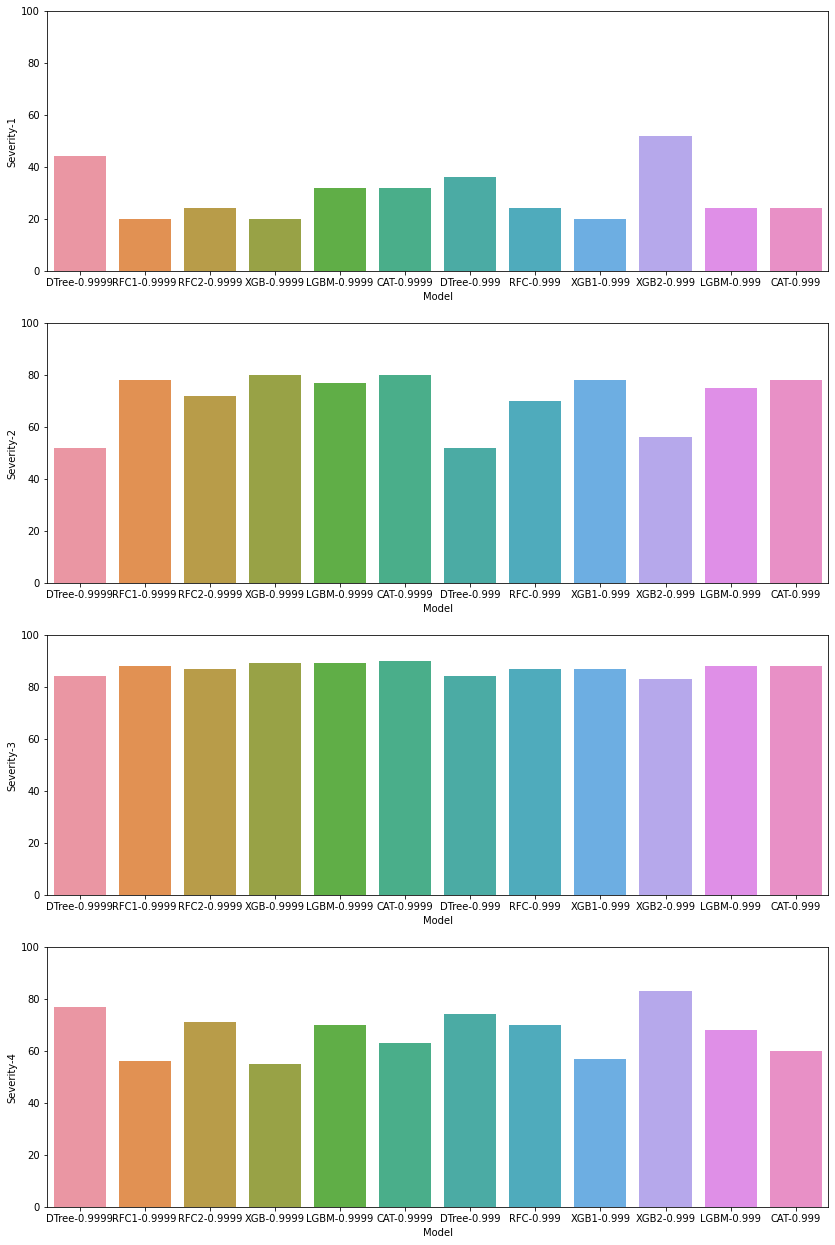

In [33]:
fig, ax = plt.subplots(4,1,figsize=(14,22))
sns.barplot(x='Model',y='Severity-1',data=result,ax=ax[0])
sns.barplot(x='Model',y='Severity-2',data=result,ax=ax[1])
sns.barplot(x='Model',y='Severity-3',data=result,ax=ax[2])
sns.barplot(x='Model',y='Severity-4',data=result,ax=ax[3])
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,100)
ax[2].set_ylim(0,100)
ax[3].set_ylim(0,100)
plt.show()